# Import Library

In [1]:
# === General Purpose ===
import numpy as np
import pandas as pd
from collections import Counter
import warnings
import sys
warnings.filterwarnings("ignore")

# === PyTorch ===
import torch

# === Data Preprocessing & Balancing ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import KFold


# === Evaluation Metrics ===
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.calibration import calibration_curve

# === Optimization ===
from bayes_opt import BayesianOptimization

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns

# === Misc ===
from tabulate import tabulate


# Set Seed

In [3]:
def set_all_seeds(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cpu


# Preprocessing

## Load Dataset

In [3]:
df = pd.read_csv("BRF.csv")

# === 2. Pisahkan fitur dan target ===
X = df.drop(columns=["HeartDiseaseorAttack"])
y = df["HeartDiseaseorAttack"]
# Mengecek distribusi kelas pada target
print(y.value_counts())

# Jika ingin lebih rapi dengan label
print("\nDistribusi kelas:")
print(y.value_counts().rename({0: "Tidak Ada Penyakit Jantung", 1: "Ada Penyakit Jantung"}))


HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64

Distribusi kelas:
HeartDiseaseorAttack
Tidak Ada Penyakit Jantung    229787
Ada Penyakit Jantung           23893
Name: count, dtype: int64


## Outlier Handling

In [4]:
# === Outlier Handling: Winsorizing BMI dan Clipping lainnya ===
def handle_outliers(df):
    df = df.copy()

    # Batasi nilai BMI ke rentang wajar medis
    df['BMI'] = df['BMI'].clip(lower=13, upper=60)

    # Clipping kasar untuk skor kesehatan (maksimum logis = 30 hari)
    df['MentHlth'] = df['MentHlth'].clip(upper=30)
    df['PhysHlth'] = df['PhysHlth'].clip(upper=30)

    return df

# Terapkan ke dataset awal
df = handle_outliers(df)


## Transformasi Skewnees

In [5]:
# === Log Transform untuk distribusi yang sangat skew ===
def transform_skewed_features(df):
    df = df.copy()

    # Log1p (log(x+1)) untuk menghindari log(0)
    df['MentHlth'] = np.log1p(df['MentHlth'])
    df['PhysHlth'] = np.log1p(df['PhysHlth'])

    return df

# Terapkan transformasi
df = transform_skewed_features(df)


## Split Dataset

In [8]:
from sklearn.model_selection import train_test_split

# Tahap 1: pisahkan test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

# Tahap 2: pisahkan validation set dari sisa (10/90 ≈ 0.111)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, stratify=y_temp, random_state=42
)

print("80/10/10 Split:")
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


# Tahap 1: pisahkan test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Tahap 2: pisahkan validation set dari sisa (15/85 ≈ 0.1765)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)

print("\n70/15/15 Split:")
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


80/10/10 Split:
Train: 202969 Val: 25343 Test: 25368

70/15/15 Split:
Train: 177569 Val: 38059 Test: 38052


## Normalisasi

In [9]:
# Tahap 1: test 10%
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

# Tahap 2: val 10% dari total (≈ 11.1% dari sisa)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, stratify=y_temp, random_state=42
)

# Normalisasi (fit hanya pada train!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Tahap 1: test 15%
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Tahap 2: val 15% dari total (≈ 17.65% dari sisa)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)

# Normalisasi (fit hanya pada train!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


# SMOTE-EEN

## Fungsi SMOTE-EEN

In [10]:
# cell fungsi smote-een:
def smote_gpu(X, y, k=5):
    # X dan y adalah NumPy array; ubah ke tensor GPU
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y).to(device)

    counter = Counter(y.cpu().numpy())
    majority_class = max(counter, key=counter.get)
    minority_class = min(counter, key=counter.get)

    X_min = X[y == minority_class]
    n_generate = counter[majority_class] - counter[minority_class]

    # Compute pairwise distances di GPU
    dist_matrix = torch.cdist(X_min, X_min)
    knn_idx = dist_matrix.topk(k=k + 1, largest=False).indices[:, 1:]

    # Pilih sampel acak
    torch.manual_seed(42)
    idx = torch.randint(0, X_min.size(0), (n_generate,))
    nn_idx = torch.randint(0, k, (n_generate,))
    base = X_min[idx]
    neighbor = X_min[knn_idx[idx, nn_idx]]

    gap = torch.rand(n_generate, 1, device=device)
    synthetic = base + gap * (neighbor - base)

    X_new = torch.cat([X, synthetic], dim=0)
    y_new = torch.cat([y, torch.full((n_generate,), minority_class, device=device)])
    new_counter = Counter(y_new.cpu().numpy())
    added_samples_per_class = {cls: new_counter.get(cls, 0) - counter.get(cls, 0) for cls in new_counter}

    print(f"Jumlah data yang ditambahkan per kelas: {added_samples_per_class}")
    return X_new.cpu().numpy(), y_new.cpu().numpy()

def enn_gpu(X, y, k=3):
    if hasattr(X, "values"):
        X = X.values
    if hasattr(y, "values"):
        y = y.values

    X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y = torch.tensor(np.array(y)).to(device)

    n = X.size(0)
    batch_size = 500
    keep_mask = torch.zeros(n, dtype=torch.bool).to(device)

    for i in range(0, n, batch_size):
        end = min(i + batch_size, n)
        X_batch = X[i:end]
        dists = torch.cdist(X_batch, X)
        topk = dists.topk(k=k + 1, largest=False).indices[:, 1:]
        pred_labels = y[topk]
        majority = (pred_labels.float().mean(dim=1) >= 0.5).long()
        keep_mask[i:end] = (majority == y[i:end])

        # Progress bar
        bar_len = 30
        filled = int(bar_len * end / n)
        bar = '=' * filled + '-' * (bar_len - filled)
        sys.stdout.write(f"\rENN Filtering [{bar}] {end}/{n}")
        sys.stdout.flush()

    print("\nENN done.")

    # Hitung distribusi sebelum dan sesudah
    from collections import Counter
    y_before = Counter(y.cpu().numpy())
    y_after = Counter(y[keep_mask].cpu().numpy())

    removed_per_class = {cls: y_before[cls] - y_after.get(cls, 0) for cls in y_before}

    retained_samples = keep_mask.sum().item()
    removed_samples = n - retained_samples
    print(f"Jumlah sampel yang dipertahankan: {retained_samples}")
    print(f"Jumlah sampel yang dibuang: {removed_samples}")
    print(f"Rincian sampel yang dihapus per kelas: {removed_per_class}")

    return X[keep_mask].cpu().numpy(), y[keep_mask].cpu().numpy()


def smote_enn_gpu(X, y):
    print("Generating synthetic samples with SMOTE...")
    X_res, y_res = smote_gpu(X, y)

    print("Cleaning with ENN...")
    X_clean, y_clean = enn_gpu(X_res, y_res)

    return X_clean, y_clean

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("Awal dataset:", X.shape, y.shape)

# SPLIT 1: 80% train, 10% val, 10% test
print("\n=== Split 80/10/10 ===")

# Step 1: pisahkan test 10%
X_temp, X_test_801010, y_temp, y_test_801010 = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

# Step 2: pisahkan val (10% total ≈ 0.111 dari sisa)
X_train_801010, X_val_801010, y_train_801010, y_val_801010 = train_test_split(
    X_temp, y_temp, test_size=0.111, stratify=y_temp, random_state=42
)

# Normalisasi (fit hanya pada train)
scaler_801010 = StandardScaler()
X_train_scaled_801010 = scaler_801010.fit_transform(X_train_801010)
X_val_scaled_801010   = scaler_801010.transform(X_val_801010)
X_test_scaled_801010  = scaler_801010.transform(X_test_801010)

# SMOTE + ENN di TRAIN
X_res_801010, y_res_801010 = smote_gpu(X_train_scaled_801010, y_train_801010.values)
print("Setelah SMOTE:", X_res_801010.shape, y_res_801010.shape)

X_clean_801010, y_clean_801010 = enn_gpu(X_res_801010, y_res_801010)
print("Masuk ENN:", X_res_801010.shape, y_res_801010.shape)
print("Setelah ENN:", X_clean_801010.shape, y_clean_801010.shape)

# SPLIT 2: 70% train, 15% val, 15% test
print("\n=== Split 70/15/15 ===")

# Step 1: pisahkan test 15%
X_temp, X_test_701515, y_temp, y_test_701515 = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Step 2: pisahkan val (15% total ≈ 0.1765 dari sisa)
X_train_701515, X_val_701515, y_train_701515, y_val_701515 = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)

# Normalisasi (fit hanya pada train)
scaler_701515 = StandardScaler()
X_train_scaled_701515 = scaler_701515.fit_transform(X_train_701515)
X_val_scaled_701515   = scaler_701515.transform(X_val_701515)
X_test_scaled_701515  = scaler_701515.transform(X_test_701515)

# SMOTE + ENN di TRAIN
X_res_701515, y_res_701515 = smote_gpu(X_train_scaled_701515, y_train_701515.values)
print("Setelah SMOTE:", X_res_701515.shape, y_res_701515.shape)

X_clean_701515, y_clean_701515 = enn_gpu(X_res_701515, y_res_701515)
print("Masuk ENN:", X_res_701515.shape, y_res_701515.shape)
print("Setelah ENN:", X_clean_701515.shape, y_clean_701515.shape)


Awal dataset: (253680, 21) (253680,)

=== Split 80/10/10 ===
Jumlah data yang ditambahkan per kelas: {0.0: 0, 1.0: 164735}
Setelah SMOTE: (367704, 21) (367704,)
ENN Filtering [==============================] 367704/367704
ENN done.
Jumlah sampel yang dipertahankan: 332667
Jumlah sampel yang dibuang: 35037
Rincian sampel yang dihapus per kelas: {0.0: 31876, 1.0: 3161}
Masuk ENN: (367704, 21) (367704,)
Setelah ENN: (332667, 21) (332667,)

=== Split 70/15/15 ===
Jumlah data yang ditambahkan per kelas: {0.0: 0, 1.0: 144121}
Setelah SMOTE: (321690, 21) (321690,)
ENN Filtering [==============================] 321690/321690
ENN done.
Jumlah sampel yang dipertahankan: 291130
Jumlah sampel yang dibuang: 30560
Rincian sampel yang dihapus per kelas: {0.0: 28036, 1.0: 2524}
Masuk ENN: (321690, 21) (321690,)
Setelah ENN: (291130, 21) (291130,)


# XGB

## Fungsi XGB

In [12]:
# Tahap 1: Inisialisasi Prediksi Awal 
import xgboost as xgb
from xgboost import XGBClassifier

class InitialLogOddsCalculator:
    def compute(self, y):
        pos_ratio = y.sum().item() / len(y)
        log_odds = np.log(pos_ratio / (1 - pos_ratio + 1e-7))  # untuk menghindari div 0
        return log_odds

# Tahap 2: Gradient dan Hessian Calculator
class GradientHessianCalculator:
    def compute(self, preds, labels):
        preds = 1 / (1 + np.exp(-preds))  # Sigmoid
        grad = preds - labels
        hess = preds * (1 - preds)
        return grad, hess

#Tahap 3: Data Preparation
class XGBDataPreparer:
    def to_dmatrix(self, X, y=None):
        X_np = X.cpu().numpy().astype(np.float32)
        if y is not None:
            y_np = y.cpu().numpy().astype(np.float32)
            return xgb.DMatrix(X_np, label=y_np)
        return xgb.DMatrix(X_np)

#Tahap 4: Parameter Configuration
class XGBParamConfigurator:
    def __init__(self, max_depth, eta, reg_lambda, gamma, tree_method, eval_metric):
        self.params = {
            'max_depth': max_depth,
            'eta': eta,
            'lambda': reg_lambda,
            'gamma': gamma,
            'objective': 'binary:logistic',
            'tree_method': tree_method,
            'eval_metric': eval_metric,
            'verbosity': 0,
            'seed': 42,
            'use_label_encoder': False
        }

    def get_params(self):
        return self.params

#Tahap 5: Booster Trainer
class XGBTrainer:
    def __init__(self, params, n_estimators):
        self.params = params
        self.n_estimators = n_estimators

    def train(self, dtrain):
        return xgb.train(self.params, dtrain, num_boost_round=self.n_estimators)

class HybridXGBoostGPU:
    def __init__(self, 
                 n_estimators=50, 
                 learning_rate=0.1, 
                 max_depth=5,
                 reg_lambda=0.0,
                 gamma=1,
                 tree_method='hist',
                 eval_metric='logloss',
                 seed=42): 
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.seed = seed  

        self.initializer = InitialLogOddsCalculator()
        self.grad_calc = GradientHessianCalculator()
        self.data_preparer = XGBDataPreparer()
        self.param_config = XGBParamConfigurator(
            max_depth, learning_rate, reg_lambda, gamma, tree_method, eval_metric
        )
        self.trainer = None
        self.booster = None
        self.init_score = None

    def fit(self, X, y):
        self.init_score = self.initializer.compute(y)
        dtrain = self.data_preparer.to_dmatrix(X, y)
        params = self.param_config.get_params()
        self.trainer = XGBTrainer(params, self.n_estimators)
        self.booster = self.trainer.train(dtrain)


    def predict_proba(self, X):
        dtest = self.data_preparer.to_dmatrix(X)
        preds = self.booster.predict(dtest)
        return torch.tensor(preds, device=X.device)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).long()


# Training Model

In [34]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def fold(X, noise_level=1e-3):
    noise = np.random.normal(0, noise_level, X.shape)
    return X + noise
    
def run_kfold(X, y, label=""):
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
        X_train_fold = torch.tensor(X[train_idx], dtype=torch.float32).to(device)
        y_train_fold = torch.tensor(y[train_idx], dtype=torch.float32).to(device)
        X_val_fold   = torch.tensor(X[val_idx], dtype=torch.float32).to(device)
        y_val_fold   = torch.tensor(y[val_idx], dtype=torch.float32).to(device)

        model = HybridXGBoostGPU(
            n_estimators=50,
            learning_rate=0.1,
            max_depth=5,
            reg_lambda=0.0,
            gamma=1,
            tree_method='hist',
            eval_metric='logloss'
        )
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_val_fold).cpu().numpy()
        y_true = y_val_fold.cpu().numpy()

        cv_results.append({
            'Fold': fold,
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1 Score': f1_score(y_true, y_pred)
        })

    df = pd.DataFrame(cv_results)
    print(f"\n=== Hasil K-Fold ({label}) ===")
    print(df)
    print(f"\nRata-rata Skor {label}:")
    print(df.mean(numeric_only=True))
    return df
    
X_clean_801010 = fold(X_clean_801010, noise_level=1e-3)


# Jalankan K-Fold untuk kedua rasio
cv_df_80 = run_kfold(X_clean_801010, y_clean_801010, label="Split 80:10:10")
cv_df_70 = run_kfold(X_clean_701515, y_clean_701515, label="Split 70:15:15")

# Perbandingan rata-rata hasil
print("\n=== Perbandingan Rata-rata ===")
comparison = pd.DataFrame({
    '80:10:10': cv_df_80.mean(numeric_only=True),
    '70:15:15': cv_df_70.mean(numeric_only=True)
})
print(comparison)



=== Hasil K-Fold (Split 80:10:10) ===
   Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.917516   0.912317  0.938320  0.925136
1     2  0.917576   0.910914  0.940203  0.925327
2     3  0.917229   0.912339  0.937711  0.924851
3     4  0.915861   0.908354  0.939925  0.923870
4     5  0.918266   0.913323  0.938596  0.925787

Rata-rata Skor Split 80:10:10:
Fold         3.000000
Accuracy     0.917290
Precision    0.911449
Recall       0.938951
F1 Score     0.924994
dtype: float64

=== Hasil K-Fold (Split 70:15:15) ===
   Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.922990   0.918180  0.942364  0.930114
1     2  0.920757   0.915796  0.940784  0.928122
2     3  0.921410   0.918464  0.938826  0.928533
3     4  0.922973   0.918203  0.942300  0.930096
4     5  0.921478   0.917831  0.939744  0.928658

Rata-rata Skor Split 70:15:15:
Fold         3.000000
Accuracy     0.921921
Precision    0.917695
Recall       0.940804
F1 Score     0.929105
dtype: float64

=== Perbandingan Ra

# Hyperparameter Tuning

## Bayesian Optimization

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from bayes_opt import BayesianOptimization
from tabulate import tabulate
import pandas as pd
import numpy as np
import torch

#  Buffer hasil semua iterasi
bo1_trials = []

# Konversi dataset 70:15:15 ke tensor
X_tensor = torch.tensor(X_clean_701515, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_clean_701515, dtype=torch.float32).to(device)

def bayes_objective(n_estimators, max_depth, learning_rate, gamma, reg_lambda):
    np.random.seed(42) 
    torch.manual_seed(42) 

    n_estimators = int(n_estimators)
    max_depth = int(max_depth)

    # Split train-val
    X_train, X_val, y_train, y_val = train_test_split(
        X_tensor, y_tensor,
        test_size=0.2,
        random_state=42,  
        stratify=y_tensor.cpu().numpy()
    )

    # Model Hybrid XGBoost di GPU
    model = HybridXGBoostGPU(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        reg_lambda=reg_lambda,
        gamma=gamma,
        tree_method='hist',
        eval_metric='logloss',
        seed=42  
    )
    
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    # Hitung recall untuk kelas positif (1)
    recall = recall_score(y_val.cpu().numpy(), preds.cpu().numpy(), pos_label=1)

    # Simpan log iterasi
    bo1_trials.append({
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': round(learning_rate, 5),
        'gamma': round(gamma, 5),
        'reg_lambda': round(reg_lambda, 5),
        'recall': round(recall, 5)
    })

    print(f"Recall iterasi: {recall:.4f}")
    return recall  


# Rentang pencarian parameter
param_bounds = {
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'gamma': (0.0, 5.0),
    'reg_lambda': (0.0, 5.0),
}

optimizer = BayesianOptimization(
    f=bayes_objective,
    pbounds=param_bounds,
    random_state=42,  
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=15)


#  Hasil dalam tabel
df_bo1 = pd.DataFrame(bo1_trials)
best_idx = df_bo1['recall'].idxmax()
df_bo1['Best'] = ['YES' if i == best_idx else '' for i in df_bo1.index]

print("\nHasil BO1 Semua Iterasi (Berdasarkan Recall):")
print(tabulate(df_bo1, headers='keys', tablefmt='grid', showindex=False, floatfmt=".4f"))

print("\nHasil BO1 Terbaik (Recall Tertinggi):")
print(tabulate(df_bo1.iloc[[best_idx]], headers='keys', tablefmt='grid', showindex=False, floatfmt=".4f"))


|   iter    |  target   | n_esti... | max_depth | learni... |   gamma   | reg_la... |
-------------------------------------------------------------------------------------
Recall iterasi: 0.9373
| 1         | 0.9372789 | 106.18101 | 9.6550001 | 0.2222782 | 2.9932924 | 0.7800932 |
Recall iterasi: 0.9327
| 2         | 0.9326680 | 73.399178 | 3.4065852 | 0.2611910 | 3.0055750 | 3.5403628 |
Recall iterasi: 0.9391
| 3         | 0.9390790 | 53.087674 | 9.7893689 | 0.2514083 | 1.0616955 | 0.9091248 |
Recall iterasi: 0.9367
| 4         | 0.9367104 | 77.510676 | 5.1296957 | 0.1621793 | 2.1597250 | 1.4561457 |
Recall iterasi: 0.9334
| 5         | 0.9333628 | 141.77793 | 3.9764570 | 0.0947219 | 1.8318092 | 2.2803499 |
Recall iterasi: 0.9335
| 6         | 0.9334891 | 141.13172 | 3.0373739 | 0.2377790 | 3.1582009 | 2.2536190 |
Recall iterasi: 0.9414
| 7         | 0.9413845 | 50.007030 | 7.3827541 | 0.1584500 | 1.4853788 | 1.9346816 |
Recall iterasi: 0.9337
| 8         | 0.9337417 | 50.053710 | 3.0 

# Perbandingan Model

## XGB vs XGB SMOTE-ENN (Baseline) VS XGB SMOTE-ENN (Fine tuned) 


Evaluasi: XGBoost Tanpa SMOTE (70/15/15)
Accuracy : 0.9082214456501747
Precision: 0.5861423220973783
Recall   : 0.08730822873082288
F1-Score : 0.1519786355911629
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     34474
         1.0       0.59      0.09      0.15      3585

    accuracy                           0.91     38059
   macro avg       0.75      0.54      0.55     38059
weighted avg       0.88      0.91      0.88     38059



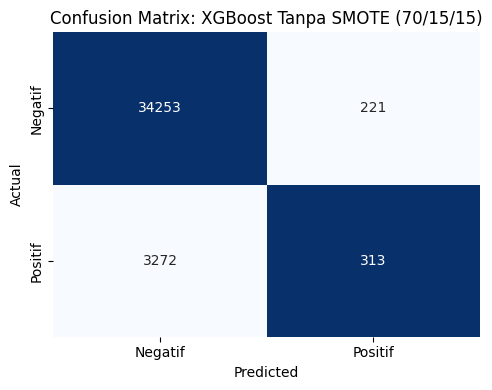


Evaluasi: XGBoost SMOTE-ENN Default (70/15/15)
Accuracy : 0.8037257941616963
Precision: 0.2798866855524079
Recall   : 0.6889818688981869
F1-Score : 0.3980660757453666
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.82      0.88     34474
         1.0       0.28      0.69      0.40      3585

    accuracy                           0.80     38059
   macro avg       0.62      0.75      0.64     38059
weighted avg       0.90      0.80      0.84     38059



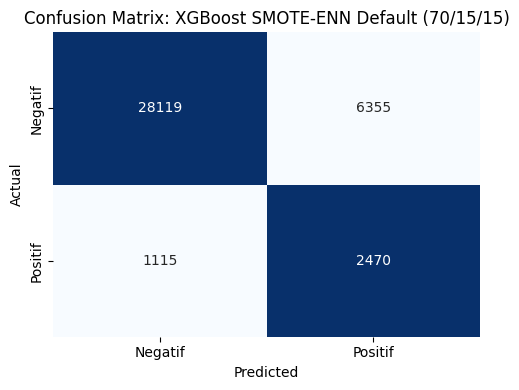


Evaluasi: XGBoost SMOTE-ENN Fine-tuned BO (70/15/15)
Accuracy : 0.8501799837095037
Precision: 0.32718367346938776
Recall   : 0.5589958158995816
F1-Score : 0.41277033985581874
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91     34474
         1.0       0.33      0.56      0.41      3585

    accuracy                           0.85     38059
   macro avg       0.64      0.72      0.66     38059
weighted avg       0.89      0.85      0.87     38059



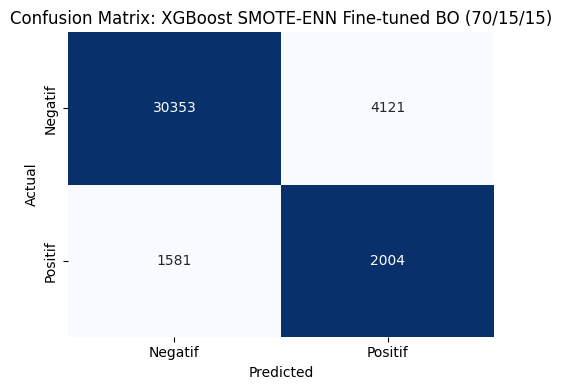

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Konversi ke Tensor
X_train_tensor = torch.tensor(X_train_scaled_701515, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_701515.values, dtype=torch.float32).to(device)

X_smote_tensor = torch.tensor(X_clean_701515, dtype=torch.float32).to(device)
y_smote_tensor = torch.tensor(y_clean_701515, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val_scaled_701515, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_701515.values, dtype=torch.float32).to(device)


#  Model 1: Tanpa SMOTE
model_plain = HybridXGBoostGPU(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=5,
    reg_lambda=0.0,
    gamma=1,
    tree_method='hist',
    eval_metric='logloss'
)
model_plain.fit(X_train_tensor, y_train_tensor)
y_pred_plain = model_plain.predict(X_val_tensor).cpu().numpy()


#  Model 2: SMOTE-ENN Default
model_smote = HybridXGBoostGPU(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=5,
    reg_lambda=0,
    gamma=1,
    tree_method='hist',
    eval_metric='logloss'
)
model_smote.fit(X_smote_tensor, y_smote_tensor)
y_pred_smote = model_smote.predict(X_val_tensor).cpu().numpy()

# Model 3: SMOTE-ENN Fine-Tuned (BO Best Params)
model_bo = HybridXGBoostGPU(
    n_estimators=50,          # hasil BO
    learning_rate=0.1411,     # hasil BO
    max_depth=7,              # hasil BO
    reg_lambda=1.5176,        # hasil BO
    gamma=1.4998,             # hasil BO
    tree_method='hist',
    eval_metric='logloss'
)
model_bo.fit(X_smote_tensor, y_smote_tensor)
y_pred_bo = model_bo.predict(X_val_tensor).cpu().numpy()


# Evaluasi & Confusion Matrix
def plot_confusion_matrix_highlight_diag(y_true, y_pred, label):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nEvaluasi: {label}")
    print("Accuracy :", acc)
    print("Precision:", prec)
    print("Recall   :", rec)
    print("F1-Score :", f1)
    print("Classification Report:\n", classification_report(y_true, y_pred, digits=2))

    # Highlight diagonal
    cm_color = np.zeros_like(cm, dtype=float)
    for i in range(len(cm)):
        cm_color[i, i] = 1  

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_color, annot=cm, fmt='d', cmap='Blues',
                xticklabels=["Negatif", "Positif"],
                yticklabels=["Negatif", "Positif"],
                cbar=False)
    plt.title(f"Confusion Matrix: {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_highlight_diag(y_val_tensor.cpu().numpy(), y_pred_plain, "XGBoost Tanpa SMOTE (70/15/15)")
plot_confusion_matrix_highlight_diag(y_val_tensor.cpu().numpy(), y_pred_smote, "XGBoost SMOTE-ENN Default (70/15/15)")
plot_confusion_matrix_highlight_diag(y_val_tensor.cpu().numpy(), y_pred_bo, "XGBoost SMOTE-ENN Fine-tuned BO (70/15/15)")


## Perbandingan Cross Validation


 Evaluasi Cross-Validation: Tanpa SMOTE

[Fold 1] Training on 142055, Validating on 35514


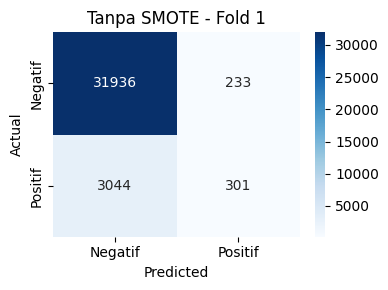


[Fold 2] Training on 142055, Validating on 35514


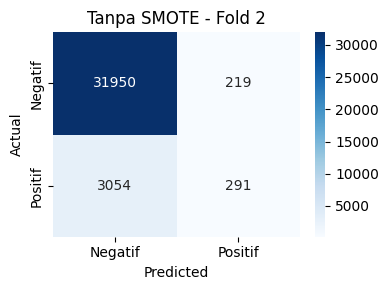


[Fold 3] Training on 142055, Validating on 35514


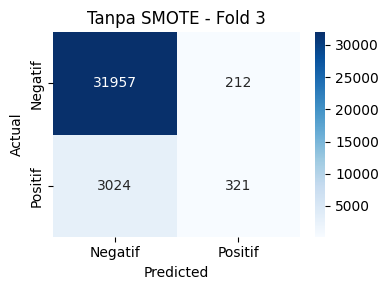


[Fold 4] Training on 142055, Validating on 35514


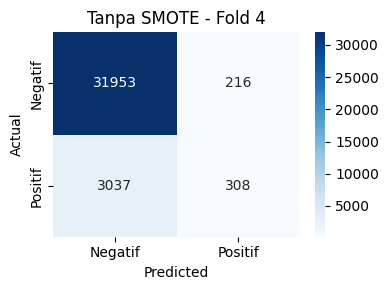


[Fold 5] Training on 142056, Validating on 35513


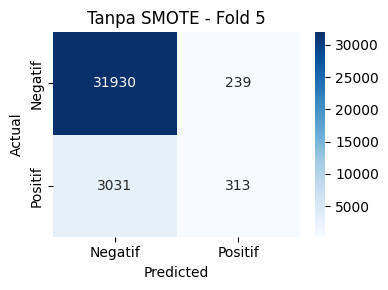


 Evaluasi Cross-Validation: SMOTE-ENN Default

[Fold 1] Training on 232904, Validating on 58226


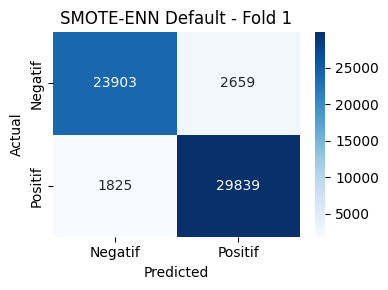


[Fold 2] Training on 232904, Validating on 58226


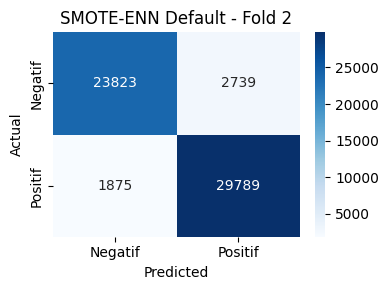


[Fold 3] Training on 232904, Validating on 58226


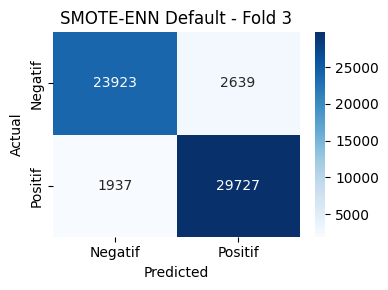


[Fold 4] Training on 232904, Validating on 58226


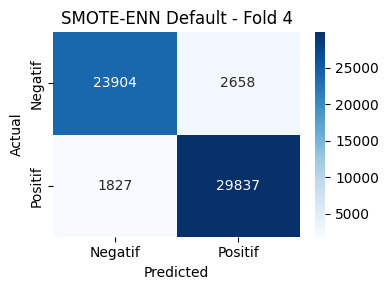


[Fold 5] Training on 232904, Validating on 58226


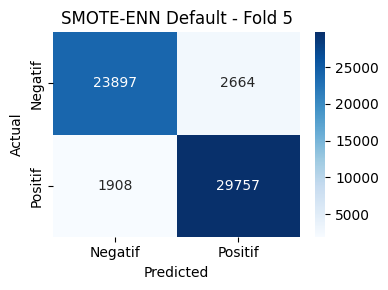


 Evaluasi Cross-Validation: SMOTE-ENN BO

[Fold 1] Training on 232904, Validating on 58226


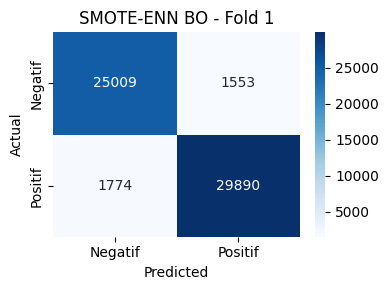


[Fold 2] Training on 232904, Validating on 58226


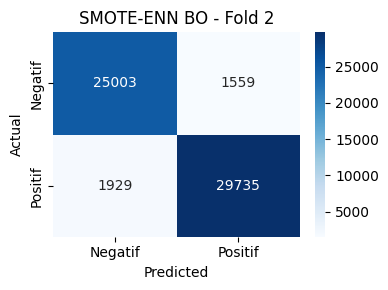


[Fold 3] Training on 232904, Validating on 58226


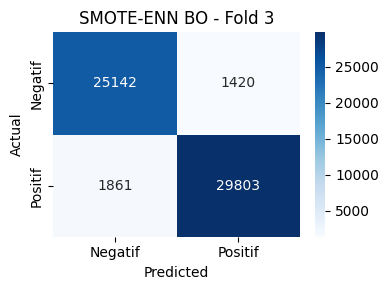


[Fold 4] Training on 232904, Validating on 58226


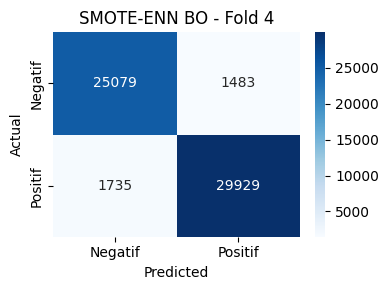


[Fold 5] Training on 232904, Validating on 58226


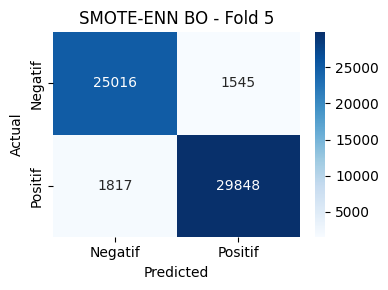


=== Perbandingan Rata-rata Skor Tiap Model ===
               Model  Accuracy  Precision  Recall  F1 Score
0       SMOTE-ENN BO    0.9427     0.9518  0.9424    0.9471
1  SMOTE-ENN Default    0.9219     0.9177  0.9408    0.9291
2        Tanpa SMOTE    0.9082     0.5783  0.0917    0.1583


In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def cross_validate_model(name, X_np, y_np, model_params):
    print(f"\n Evaluasi Cross-Validation: {name}")
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_np, y_np), 1):
        print(f"\n[Fold {fold}] Training on {len(train_idx)}, Validating on {len(val_idx)}")

        X_train = torch.tensor(X_np[train_idx], dtype=torch.float32).to(device)
        y_train = torch.tensor(y_np[train_idx], dtype=torch.float32).to(device)
        X_val = torch.tensor(X_np[val_idx], dtype=torch.float32).to(device)
        y_val = torch.tensor(y_np[val_idx], dtype=torch.float32).to(device)

        model = HybridXGBoostGPU(**model_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val).cpu().numpy()
        y_true = y_val.cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)

        # Confusion Matrix per fold
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["Negatif", "Positif"],
                    yticklabels=["Negatif", "Positif"])
        plt.title(f"{name} - Fold {fold}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        results.append({
            'Model': name,
            'Fold': fold,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1
        })

    return pd.DataFrame(results)


# Model 1: Tanpa SMOTE (pakai train asli)

params_plain = {
    'n_estimators': 50,
    'learning_rate': 0.1,
    'max_depth': 5,
    'reg_lambda': 0.0,
    'gamma': 1,
    'tree_method': 'hist',
    'eval_metric': 'logloss'
}
df_plain = cross_validate_model("Tanpa SMOTE", X_train_scaled_701515, y_train_701515.values, params_plain)



# Model 2: SMOTE-ENN Default (pakai data resampling)

params_smote = {
    'n_estimators': 50,
    'learning_rate': 0.1,
    'max_depth': 5,
    'reg_lambda': 0.0,
    'gamma': 1.0,
    'tree_method': 'hist',
    'eval_metric': 'logloss'
}
df_smote = cross_validate_model("SMOTE-ENN Default", X_clean_701515, y_clean_701515, params_smote)



params_bo = {
    'n_estimators': 50,          
    'learning_rate': 0.1411,     
    'max_depth': 7,              
    'reg_lambda': 1.5176,        
    'gamma': 1.4998,             
    'tree_method': 'hist',
    'eval_metric': 'logloss'
}
df_bo = cross_validate_model("SMOTE-ENN BO", X_clean_701515, y_clean_701515, params_bo)


# =========================
# 🔹 Gabungkan Semua Hasil
# =========================
df_all = pd.concat([df_plain, df_smote, df_bo])
df_avg = df_all.groupby("Model")[['Accuracy', 'Precision', 'Recall', 'F1 Score']].mean().reset_index()

print("\n=== Perbandingan Rata-rata Skor Tiap Model ===")
print(df_avg.round(4))


# Testing

In [26]:

X_test_tensor = torch.tensor(X_test_scaled_701515, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_701515.values, dtype=torch.float32).to(device)

class_1_indices = (y_test_tensor == 1).nonzero(as_tuple=True)[0]
class_0_indices = (y_test_tensor == 0).nonzero(as_tuple=True)[0]

#prediksi dengan model
model_bo = HybridXGBoostGPU(**params_bo)
model_bo.fit(
    torch.tensor(X_clean_701515, dtype=torch.float32).to(device),
    torch.tensor(y_clean_701515, dtype=torch.float32).to(device)
)

# Prediksi kelas 1 dan 0
y_class_1_pred = model_bo.predict(X_test_tensor[class_1_indices])
y_class_0_pred = model_bo.predict(X_test_tensor[class_0_indices])
y_class_1_proba = model_bo.predict_proba(X_test_tensor[class_1_indices])
y_class_0_proba = model_bo.predict_proba(X_test_tensor[class_0_indices])

correct_1_indices = class_1_indices[(y_class_1_pred == 1).nonzero(as_tuple=True)[0]][:5]
correct_0_indices = class_0_indices[(y_class_0_pred == 0).nonzero(as_tuple=True)[0]][:5]

# Gabungkan indeks untuk ditampilkan
correct_indices = torch.cat([correct_1_indices, correct_0_indices])
X_correct = X_test_tensor[correct_indices]
y_correct = y_test_tensor[correct_indices]
y_pred_correct = model_bo.predict(X_correct)
y_proba_correct = model_bo.predict_proba(X_correct)

# Tampilkan hasil
for i in range(len(y_correct)):
    print(f"Sample {i+1}")
    print(f"Label Asli   : {int(y_correct[i].item())}")
    print(f"Probabilitas : {y_proba_correct[i].item():.4f}")
    print(f"Prediksi     : {int(y_pred_correct[i].item())}")
    print("-" * 30)


Sample 1
Label Asli   : 1
Probabilitas : 0.5067
Prediksi     : 1
------------------------------
Sample 2
Label Asli   : 1
Probabilitas : 0.8678
Prediksi     : 1
------------------------------
Sample 3
Label Asli   : 1
Probabilitas : 0.6371
Prediksi     : 1
------------------------------
Sample 4
Label Asli   : 1
Probabilitas : 0.8572
Prediksi     : 1
------------------------------
Sample 5
Label Asli   : 1
Probabilitas : 0.8052
Prediksi     : 1
------------------------------
Sample 6
Label Asli   : 0
Probabilitas : 0.0932
Prediksi     : 0
------------------------------
Sample 7
Label Asli   : 0
Probabilitas : 0.1686
Prediksi     : 0
------------------------------
Sample 8
Label Asli   : 0
Probabilitas : 0.0176
Prediksi     : 0
------------------------------
Sample 9
Label Asli   : 0
Probabilitas : 0.0516
Prediksi     : 0
------------------------------
Sample 10
Label Asli   : 0
Probabilitas : 0.0186
Prediksi     : 0
------------------------------
